# Homework 3

In the last homework we explored criticality in a simple fuel pin array. While this is an awesome exercise, the benifits of OpenMC extend far beyond these simple calculations. The goal of this homework is to expose you to some of the more useful features of openmc: depletions and complex geometry modeling. After that you will work with your group to apply these principles and begin to think about what it would take to model the reactor you will be designing.

This homework has 3 parts:

 ####  <center> 1) Exploration of Depletion Calculations

 #### <center> 2) Exploration of Complex Reactor Geometries 

 #### <center> 3) Application of the Principles (Group Work) 

Each has been designed to ecourage understanding more than ability. You may not be an OpenMC wizzard by the end of this class, but you should be able to understand a little better about how these calculations are done. If for some reason your code breaks or will not run, do not spend more than 15 minutes trying to fix it. Make a note explaining what broke, why you think it happend, what you would do to fix it if you had more time, and then move on! 
    
Submision Requirments:

1) Answers to the questions in blue at the end of each part. Include any graphs, figures or data you feel is appropriate.
    
2) Your modified Reactor Notebook. Inset this comment next to your modification(s) so that they are easy to find: #I CHANGED THIS HERE#
    
    

## Exploration of Depletion Calculations

This section is modeled after the example notebook 'Depletion'. The original can be found here:
https://nbviewer.org/github/openmc-dev/openmc-notebooks/blob/main/depletion.ipynb

If you have a real power reactor, the fuel composition is constantly changing as fission events produce energy, remove some fissile isotopes, and produce fission products. Other reactions, like  (𝑛,𝛼)
  and  (𝑛,𝛾)
  will alter the composition as well. Furthermore, some nuclides undergo spontaneous decay with widely ranging frequencies. Depletion is the process of modeling this behavior.
  
In this next section we will walk through a very simple depletion calculation. This has been modified from the original to account for bugs in OpenMC V-14. If you run into errors, do not spend more than 10-15 minutes trying to resolve them.  

### Getting the Depletion Chain 

Depletions runs use a special xml file that will tell the simulation how diffrent nuclides transmute over time. These depletion chains are specific to the reactor, but can often be approximated. Most chains are far to large to be run on a personal computer. For this example we will need to use a simplified chain found on github.

1) Navigate to: https://github.com/openmc-dev/openmc/blob/develop/tests/chain_simple.xml

2) Download this chain by clicking the download button
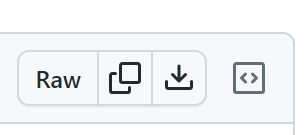

3) Move the Chain file from your Downloads folder onto the Linuix side of your Machine. Make sure it is in the same directory as this notebook. (remember, an example of how to move files to the linux side of your machine is given in the first set of openmc slides)

### Building the Model

The model constructed here is similar to that used in the last homework, a simple fuel pin.

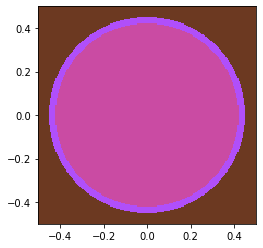

In [1]:
%matplotlib inline
import math
import openmc
fuel = openmc.Material(name="uo2")
fuel.add_element("U", 1, percent_type="ao", enrichment=4.25)
fuel.add_element("O", 2)
fuel.set_density("g/cc", 10.4)

clad = openmc.Material(name="clad")
clad.add_element("Zr", 1)
clad.set_density("g/cc", 6)

water = openmc.Material(name="water")
water.add_element("O", 1)
water.add_element("H", 2)
water.set_density("g/cc", 1.0)
water.add_s_alpha_beta("c_H_in_H2O")
materials = openmc.Materials([fuel, clad, water])

radii = [0.42, 0.45]

pin_surfaces = [openmc.ZCylinder(r=r) for r in radii]
pin_univ = openmc.model.pin(pin_surfaces, materials)

bound_box = openmc.rectangular_prism(1.24, 1.24, boundary_type="reflective")
root_cell = openmc.Cell(fill=pin_univ, region=bound_box)
geometry = openmc.Geometry([root_cell])

geometry.root_universe.plot()

settings = openmc.Settings()
settings.particles = 100
settings.inactive = 10
settings.batches = 50

fuel.volume = math.pi * radii[0] ** 2



### Setting Up for Depletion


In [2]:
import openmc.deplete
chain = openmc.deplete.Chain.from_xml("chain_simple.xml")
chain.nuclide_dict
chain_file = "chain_simple.xml"
model = openmc.model.Model(geometry=geometry, settings=settings)
operator = openmc.deplete.Operator(geometry, settings, chain_file=chain_file)
power = 174
time_steps = [30] * 6
integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d')
integrator.integrate()

### Processing the Outputs 
  

In [3]:
!ls *.h5
results = openmc.deplete.ResultsList("./depletion_results.h5")
results = openmc.deplete.ResultsList.from_hdf5("depletion_results.h5")
time, keff = results.get_eigenvalue()
time /= (24 * 60 * 60)  # convert back to days from seconds
keff

depletion_results.h5	 openmc_simulation_n3.h5  statepoint.120.h5
openmc_simulation_n0.h5  openmc_simulation_n4.h5  statepoint.50.h5
openmc_simulation_n1.h5  openmc_simulation_n5.h5  summary.h5
openmc_simulation_n2.h5  openmc_simulation_n6.h5


array([[1.47476894, 0.01395872],
       [1.44733964, 0.01490756],
       [1.45989721, 0.01404682],
       [1.43365138, 0.01564549],
       [1.4343352 , 0.01311323],
       [1.40861036, 0.01430175],
       [1.42323615, 0.0161989 ]])

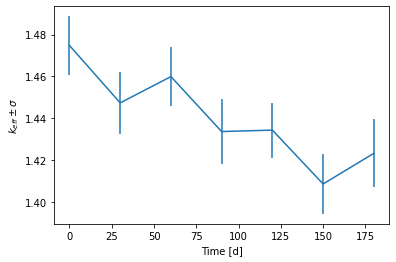

In [4]:
from matplotlib import pyplot
pyplot.errorbar(time, keff[:, 0], yerr=keff[:, 1])
pyplot.xlabel("Time [d]")
pyplot.ylabel("$k_{eff}\pm \sigma$");

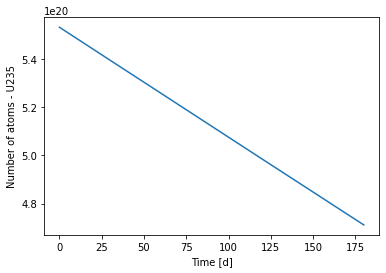

In [5]:
_, u235 = results.get_atoms("1", "U235")
_, xe135 = results.get_atoms("1", "Xe135")
pyplot.plot(time, u235, label="U235")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U235");

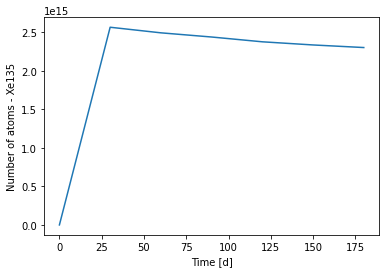

In [6]:
pyplot.plot(time, xe135, label="Xe135")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Xe135");

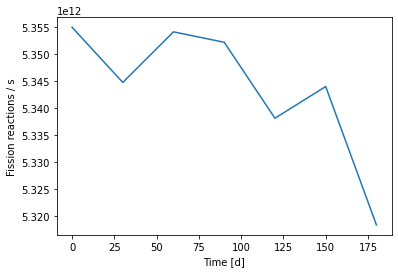

In [7]:
_, u235_fission = results.get_reaction_rate("1", "U235", "fission")
pyplot.plot(time, u235_fission)
pyplot.xlabel("Time [d]")
pyplot.ylabel("Fission reactions / s");

## Questions for Part 1: Exploration of Depletion Calculations 



- <font color='blue'>**What is the reson for the line** fuel.volume = ... , **why would volume be important to a depletion calculation?**</font>



- <font color='blue'>**What does a depletion chain tell us? Why might they be specific to the reactor?**</font>


- <font color='blue'>**Explain why or why not the results of your depletion calculation are what would be expected? Explain what each of the four graphs is depicting?**</font>



##  Exploration of Complex Reactor Geometries

For this section of the homework, I would like you to become familiar with what it takes to model the complex geometries of diffrent kinds of reactor cores. 

Please proceed to the OpenMC examples githup page: https://github.com/openmc-dev/openmc/wiki/Example-Jupyter-Notebooks

There you will see a section titled "Reactor Examples", choose one that you would like to work with. 

To download your selected reactor file, click the link. This will open the notebook viwer. From there, click the donload icon on the right corner. This will open a page of code. Right-click on that page and select Save As...

When the file explorer window opens, save the file to your Downloads. Make sure that thefile ends in .ipynb and not .txt or some other extension. If needed, .txt can be removed by renaming the file.

Once the file is downoaded, move it to the Linux side of your computer as we have done before (Windows users only, instructions are on the slides from the first openmc class)

Note: The VHTR has some interesting geometry, but is too large to simulate on a personal computer. Feel free to select it, but understand that if you modify the provided code by adding openmc.run() you might crash your computer.

### What to do with the file once its downloaded

Once you have the file on the Linux side of your computer, we are ready to open it.

With the notebook open, run every cell to ensure it works. As you do, pay attention to what each is doing. If something breaks, do not spend more than 10-15 minutes trying to fix it. Just make a note of what happend and do your best to complete what protions of the asignment you can.

Once you have veriffied that everything works, we will do two things: 

1) Choose a portion of the file that you feel you understand well. Modify it as you wish and see what happens. Ideas might include:
- *Changing Fuel Composition/Enrichment*
- *Changing the Clading, Coolant or Moderator*
- *Adjusting the Fuel Radius*
- *Removing Periodic Boundaries* 
- ...

Inset this comment next to your modification(s) so that they are easy to find: #I CHANGED THIS HERE#

2) Find a section of the code that confuses you. Do your best to figure that portion of the code out.



## Questions for Part 2: Exploration of Complex Reactor Geometries 

- <font color='blue'>**Which Reactor did you choose?**</font>


- <font color='blue'>**What did you choose to modify? What does that change mean for the physical system?**</font>


- <font color='blue'>**How did your modification effect the opperation of the reactor? Did it change the criticality? How do you think it would impact the lifetime of the reactor? (think about what you would expect to be difrent for a depletion run)**</font>


- <font color='blue'>**What difficult portion of the code did you choose to work with? What did you learn?**</font>


- <font color='blue'>**What questions do you still have?**</font>


## Application of the Principles (Group Work)

Now that you are more familiar with OpenMC, and how complex reactors can be modeled, this next portion of the homework will focus on applying these tools to the reactor design your team will eventualy be working with. 

After HW 1, your team should have a rough idea of what you design will be. With your group, visit https://aris.iaea.org/ and find a reactor that resembles what your group envisioned. Find good graphics depicting the core structure as well as information on the materials found in the core. With your group, discuss how you would begin to model this reactor in openmc. Use the homework questions to guide this discussion. 



## Questions for Part 3: Application of Principles 

- <font color='blue'>**Which Reactor did you choose? What is the biggest diffrence between it, and the reactor your group will be designing?**</font>


- <font color='blue'>**Looking over the design you chose, what do you think would be most challenging to model in OpenMC?**</font>


- <font color='blue'>**Where would you start? Is the reactor core divisable into smaller units? Where would you place periodic boundaries to simplify your simulation?**</font>


- <font color='blue'>**What materials are present in the reactor? Choose one complex material (Steel, Hastalloy, Inconell, Borrated Water, ect.). Find the elemental composition for that material (specify wo/ao), and report its density at a temprature reasonable for the reactor you selected.**</font>


- <font color='blue'>**Reusing Code is always helpful, if you do it right. Are there things we have lready coded that could be repurposed to model a portion of this design?**</font>
